# `hw2`: Inference of Oxygen Saturation from Photoplethysmography


Deadline: **Monday, November 25, 11:59 PM**. 
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- Homeworks are carried out *individually*.

In [1]:
# Fill in this cell with your personal details:
# - Name: Yang Lei
# - Student ID: S201670
# - Email: Lei.Yang@student.uliege.be

In this homework, you will have to infer oxygen saturation (SPO2 / SO2) measures from unprocessed photoplethysmography (PPG) using data from the [OpenOximetry Repository](https://physionet.org/content/openox-repo/1.0.1). You will build a small probabilistic model of PPG from SpO2, and infer some physical parameters along with the unknown SpO2 from the observed PPG data. See Homework 1 for instructions on how to handle the dataset.

# Oximeter

An [oximeter](https://en.wikipedia.org/wiki/Pulse_oximetry) is a medical device that you might have seen clipped onto someone's fingertip at a hospital. It estimates **blood oxygen saturation** ($\text{SpO}_2$) by shining light through the skin at two different wavelengths (red at $\lambda = 660 \text{ nm}$ and infrared at $\lambda = 940 \text{ nm}$) and measuring how much light passes through. This measurement technique produces two [photoplethysmographs](https://en.wikipedia.org/wiki/Photoplethysmogram) (PPG signals) - one for each wavelength.

PPG is a non-invasive method that measures changes in blood volume in tissue using light. When your heart beats, the volume of blood in your vessels changes, which affects how much light is absorbed or reflected by the tissue. Think of it like shining a flashlight through your finger - the amount of light that passes through changes slightly with each heartbeat.

The oxygen saturation ($\text{SpO}_2$) represents the percentage of hemoglobin (the protein in red blood cells that carries oxygen) that is carrying oxygen. Mathematically, it's defined as
$$
    \text{SpO}_2 = \frac{[\text{HbO}_2]}{[\text{HbO}_2] + [\text{Hb}]},
$$
where $[\text{HbO}_2]$ is the concentration of oxygenated hemoglobin and $[\text{Hb}]$ is the concentration of deoxygenated hemoglobin. A healthy person typically has $\text{SpO}_2$ levels between 95-100%.

The PPG signal has two main components:
1. The **pulsative component** (AC) represents the changing part of the signal that varies with each heartbeat;
2. The **non-pulsative component** (DC) represents the relatively constant background signal.

Think of this like waves on the ocean: AC is like the waves on the surface, while DC is like the ocean's depth. For a cardiac cycle from time $t_1$ to $t_2$, these components are defined as
$$
    \text{AC}(\lambda) = \max(\text{PPG}(\lambda)_{t_1:t_2}) - \min(\text{PPG}(\lambda)_{t_1:t_2})
$$
$$
    \text{DC}(\lambda) = \text{mean}(\text{PPG}(\lambda)_{t_1:t_2})
$$

Since many factors can affect how light passes through tissue (like skin color, thickness, or even the presence of nail polish), oximeters use a ratio ($R$) that helps cancel out these interfering factors. This ratio compares the pulsative components at both wavelengths, normalized by their respective non-pulsative components:

$$
    R
    =
    \frac{
        \text{AC}(660 \text{ nm})/\text{DC}(660 \text{ nm})
    }{
        \text{AC}(940 \text{ nm})/\text{DC}(940 \text{ nm})
    }
$$

This ratio $R$ has a known relationship with $\text{SpO}_2$, which allows us to estimate oxygen levels without drawing blood. The different absorption patterns of oxygenated and deoxygenated hemoglobin at these two wavelengths make this estimation possible.

## Probabilistic Model

In this homework, we will build a probabilistic model that relates oxygen saturation ($\text{SpO}_2$) to the observed ratio ($R$) through five parameters:
- $\sigma^2$: variance parameter capturing measurement uncertainty,
- $\epsilon_{\text{HbO}_2}(660 \text{ nm})$: absorption coefficient of oxygenated hemoglobin at red light,
- $\epsilon_{\text{Hb}}(660 \text{ nm})$: absorption coefficient of deoxygenated hemoglobin at red light,
- $\epsilon_{\text{HbO}_2}(940 \text{ nm})$: absorption coefficient of oxygenated hemoglobin at infrared light,
- $\epsilon_{\text{Hb}}(940 \text{ nm})$: absorption coefficient of deoxygenated hemoglobin at infrared light.

Our model is based on the Beer-Lambert law, a fundamental principle in spectroscopy. This law states that the absorption of light by a substance in solution is proportional to its concentration. For blood at a given wavelength $\lambda$, we can write
$$
    A(\lambda) = \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(\lambda) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(\lambda).
$$

This equation tells us that the total absorption is a weighted average of the absorption by oxygenated and deoxygenated hemoglobin, where the weights are determined by the oxygen saturation level.

We then assume that the ratio ($R$) of normalized pulsative signals is proportional to the ratio of absorptions at the two wavelengths. To account for measurement noise and other sources of uncertainty, we model $R$ as following a Normal distribution. That is, 
$$
    R
    \sim
    \mathcal{N}\left(
        \frac{
            \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(660 \text{ nm}) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(660 \text{ nm})
        }{
            \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(940 \text{ nm}) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(940 \text{ nm})
        },
        \sigma^2
    \right).
$$

In this model, both the input ($\text{SpO}_2$) and the five parameters are unknown and need to be estimated from the data. However, we report below some empirical values for the absorption coefficients that should help you set reasonable priors for these parameters. Further reference values can be found at [omlc.org/spectra/hemoglobin/summary.html](https://omlc.org/spectra/hemoglobin/summary.html).

<div class="alert alert-info">
    
**Information**. We provide the functions `extract_beats` and some empirical absorption coefficients.
    
</div>

In [2]:
import os
import emcee
import corner
import warnings
import wfdb as wf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from scipy.stats import norm, gamma
from scipy.signal import butter, filtfilt, resample, find_peaks

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
EPS_HBO2_660 = 319.6
EPS_HB_660 = 3226.56

EPS_HBO2_940 = 1214
EPS_HB_940 = 693.44

In [4]:
def extract_beats(ppg, f_ppg, min_time_between=0.4):
    """
    Arguments:
    ----------
    ppg: np.ndarray
        A one dimensional time series of ppg data (red or ir).
    f_ppg: int
        The sampling frequency (Hz).
    min_time_between: float
        The minimal time between two heartbeats.

    Returns:
    --------
    - peaks: np.ndarray
        The indices of the heartbeats peaks in the ppg time series.
    """
    min_number_between = int(min_time_between * f_ppg)
    peaks, _ = find_peaks(ppg, distance=min_number_between)
    return peaks

# Exercises

- Solve the exercises below by making the best use of the API offered in the imported libraries.
- You will also need to use the `wfdb` library for reading and writing waveform data (see [WFDB Documentation](https://wfdb.readthedocs.io/en/latest/wfdb.html)).
- For plots, feel free to use `matplotlib`, `seaborn` or `pandas` built-in plotting functions.
- Follow the data visualization principles as best as possible to make your plots effective and readable.
- For each exercise, add Markdown cells to explain what you are doing and to discuss your results.

<div class="alert alert-info">
    
**Information**. In this homework, we focus on encounter `c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779`. Below, we load the SpO2 data from `f'{encounter_id}_2hz.csv'` (device 59) and the PPG data from `f'{encounter_id}_ppg.dat'`. 
    
</div>

<div class="alert alert-danger">

**Warning**. Note that the PPG recording starts approximately 2.80 min after the SpO2, and it is shifted accordingly.

</div>

In [5]:
encounter_id = "c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779"

In [6]:
f_spo2 = 2

start = 5 * 60

saturation = pd.read_csv(f'data/waveforms/{encounter_id[0]}/{encounter_id}_2hz.csv')
spo2 = saturation['dev59_SpO2'].to_numpy()[start * f_spo2:]
t_spo2 = np.arange(spo2.shape[0]) / (60 * f_spo2)

In [7]:
f_ppg = 86

start = (5 - 2.8) * 60

ppg, ppg_info = wf.rdsamp(f'data/waveforms/{encounter_id[0]}/{encounter_id}_ppg')
ppg = ppg[int(start * f_ppg):]

ir = ppg[:, 0]
red = ppg[:, 1]
t_ppg = np.arange(len(red)) / (60 * f_ppg)

## Part 1: Data Preparation

<div class="alert alert-success">

**Exercise**. Display the SpO2 data along with the red and infrared PPG data on a single figure.

</div>

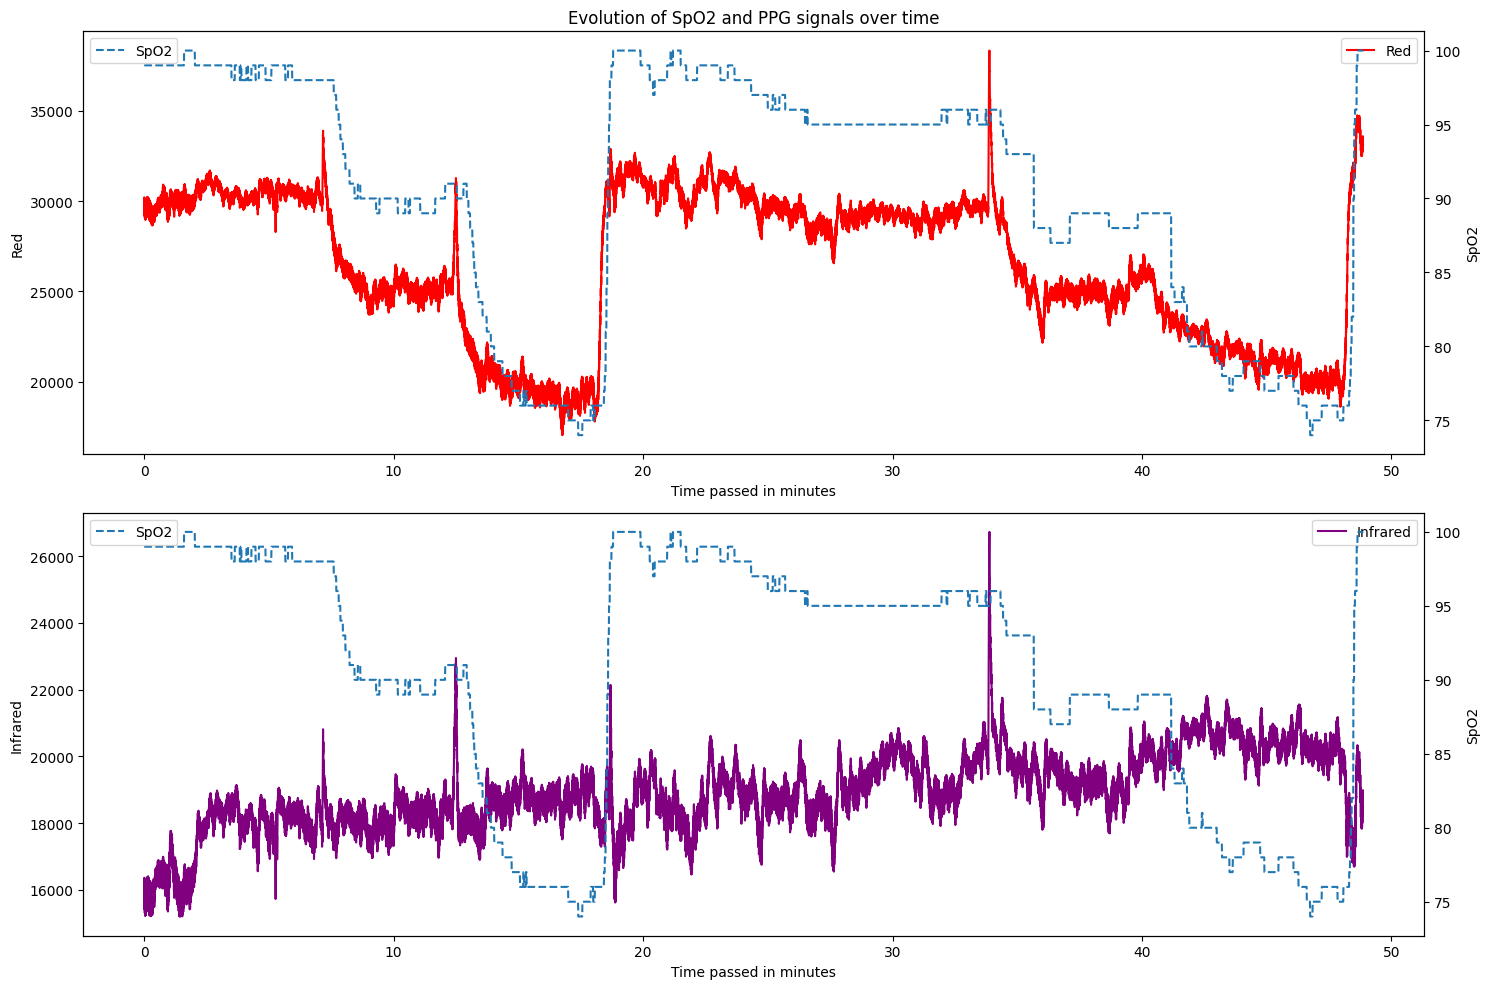

In [8]:
fig,axs = plt.subplots(figsize=(15, 10),nrows= 2, ncols=1)
axs = axs.flatten()

axs[0].plot(t_ppg,red,label='Red',color='red')
ax2 = axs[0].twinx()
ax2.plot(t_spo2, spo2, label='SpO2', linestyle='dashed')
axs[0].set_xlabel('Time passed in minutes')
axs[0].set_ylabel('Red')
ax2.set_ylabel('SpO2')
axs[0].legend(loc='upper right')
ax2.legend(loc='upper left')

axs[1].plot(t_ppg,ir,label='Infrared',color='purple')
ax3 = axs[1].twinx()
ax3.plot(t_spo2, spo2, label='SpO2', linestyle='dashed')
axs[1].set_xlabel('Time passed in minutes')
axs[1].set_ylabel('Infrared')
ax3.set_ylabel('SpO2')
axs[1].legend(loc='upper right')
ax3.legend(loc='upper left')
axs[0].set_title('Evolution of SpO2 and PPG signals over time')
plt.tight_layout()
plt.show()




<div class="alert alert-success">
    
**Exercise**. Using the function `extract_beats`, find all starts of cardiac cycles (the peak of the heart beat) $t_1, t_2, \dots, t_N$ using one of the two PPG signals (red or infrared). Then, select a random heart cycle, defined by its span $[t_k:t_{k+1}]$, and display both PPG time series $\text{PPG}(\lambda)_{t_k:t_{k+1}}$ during that heart cycle. Finally, display the distribution of the PPG time series over all heart cycles (or a subsample of a all heart cycles). 
    
</div>

<div class="alert alert-info">

**Hint**. You may want to remove the nonpulsative component $\text{DC}(\lambda)_{k}$ of the each time series $\text{PPG}(\lambda)_{t_k:t_{k+1}}$ for displaying the distribution.

</div>

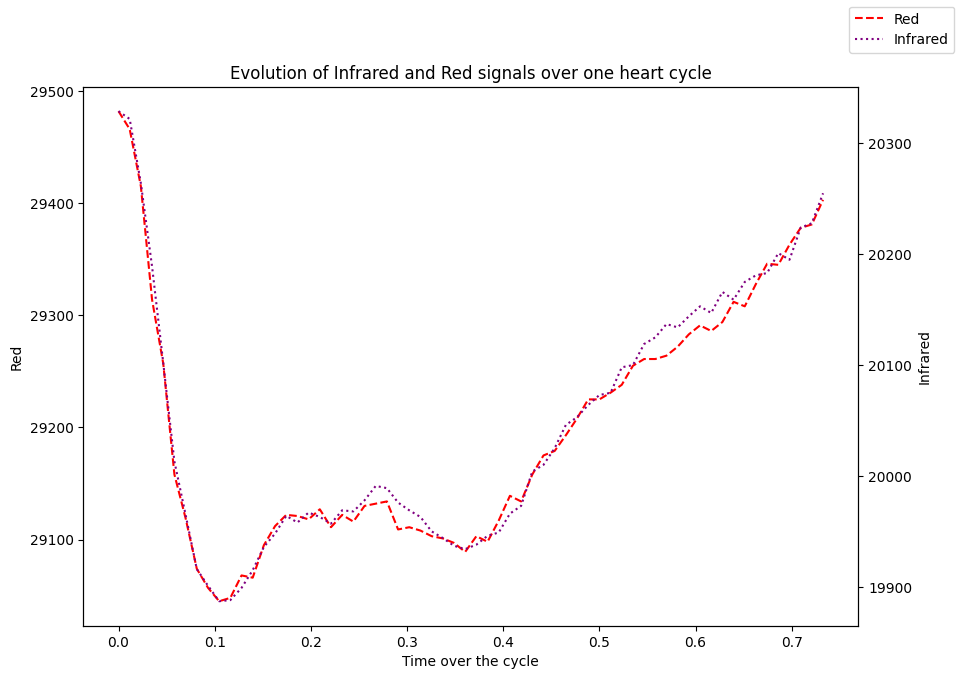

In [9]:
np.random.seed(0)

peaks = extract_beats(red, f_ppg)

random_position= np.random.randint(0, len(peaks) -1)

peaks_t1 = peaks[random_position]
peaks_t2 = peaks[random_position + 1]

ir_peak = ir[peaks_t1:peaks_t2]
red_peak= red[peaks_t1:peaks_t2]

t = np.arange(len(ir_peak)) / f_ppg

fig = plt.figure(figsize=(10,7))
ax1 = plt.axes()

ax1.plot(t, red_peak, label='Red',linestyle='--',color = 'red')
ax2 = ax1.twinx()
ax2.plot(t, ir_peak, label='Infrared', linestyle='dotted', color = 'purple')
ax1.set_xlabel('Time over the cycle')
ax1.set_ylabel('Red')
ax2.set_ylabel('Infrared')
fig.legend(loc='upper right')
plt.title('Evolution of Infrared and Red signals over one heart cycle')
plt.show()


I decide to use the red one because the first graphics is the red one will follow more the look like more in visualization than the infrared one

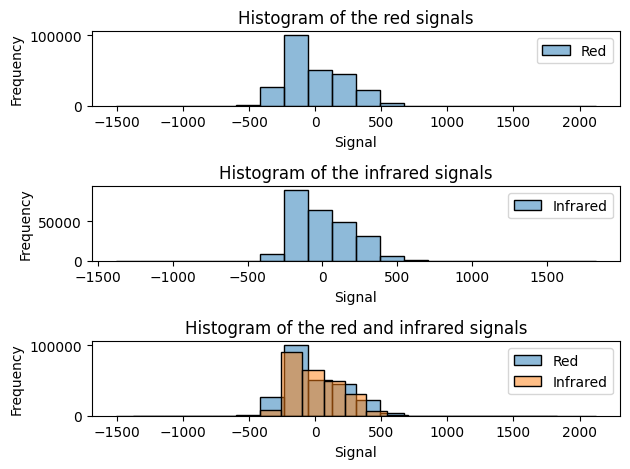

In [10]:
red_array = np.array([])
ir_array = np.array([])

for i in range(len(peaks) - 1):
    start = peaks[i]
    end = peaks[i + 1]
    red_array = np.append(red_array, red[start:end] - np.mean(red[start:end]))
    ir_array = np.append(ir_array, ir[start:end] - np.mean(ir[start:end]))

red_array = np.array(red_array).flatten()
ir_array = np.array(ir_array).flatten()
fig ,ax= plt.subplots(nrows=3, ncols=1)
ax = ax.flatten()
sns.histplot(red_array, bins=20,alpha=0.5, label='Red',ax=ax[0])
ax[0].set_xlabel('Signal')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[0].set_title('Histogram of the red signals')

sns.histplot(ir_array, bins=20,alpha=0.5, label='Infrared',ax=ax[1])
ax[1].set_xlabel('Signal')
ax[1].set_ylabel('Frequency')
ax[1].legend()
ax[1].set_title('Histogram of the infrared signals')

sns.histplot(red_array, bins=20,alpha=0.5, label='Red',ax=ax[2])
sns.histplot(ir_array, bins=20,alpha=0.5, label='Infrared',ax=ax[2])
ax[2].set_xlabel('Signal')
ax[2].set_ylabel('Frequency')
ax[2].legend()
ax[2].set_title('Histogram of the red and infrared signals')
plt.tight_layout()
plt.show()

<div class="alert alert-success">
    
**Exercise**. For both PPG signals, compute the pulsative component ($\text{AC}(\lambda)$) and non pulsative component ($\text{DC}(\lambda)$) for each heart cycle. Then, compute the ratio $R$ of normalized pulsative components. 

You now have $N$ ratios (one for each cardiac cycle), and $M$ saturation measurements (one every 0.5 second). Resample the ratio $R$ at the same times as the $\text{SpO2}$ time series so that the two time series are paired.
    
</div>

In [11]:
def AC(signal ,peaks):
    ac = np.zeros(len(peaks)-1)
    for i in range (0, len(peaks)-1):
        start = peaks[i]
        end = peaks[i+1]
        ac[i] = np.max(signal[start:end]) - np.min(signal[start:end])
    return ac

def DC(signal ,peaks):
    dc = np.zeros(len(peaks)-1)
    for i in range (0, len(peaks)-1):
        start = peaks[i]
        end = peaks[i+1]
        dc[i] = np.mean(signal[start:end])
    return dc

def R(ac_ir, ac_red, dc_ir, dc_red):
    r = np.zeros(len(ac_ir))
    for i in range(len(ac_ir)):
        r[i] =  (ac_red[i] / dc_red[i])/ (ac_ir[i] / dc_ir[i]) 
    return r

ac_red = AC(red, peaks)
ac_ir = AC(ir, peaks)
dc_red = DC(red, peaks)
dc_ir = DC(ir, peaks)

r = R(ac_ir, ac_red, dc_ir, dc_red)

r_resampled = resample(r, len(spo2))



<div class="alert alert-success">

**Exercise**. Display the SpO2 data along with the infered SpO2 data using the empirical law $\text{SpO2} = 110 - 25 R$. Discuss the results.

</div>

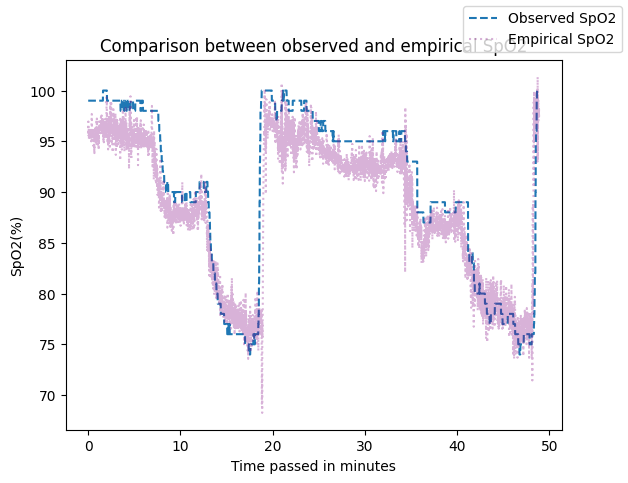

In [46]:

def empirical_law(spo2, r):
    empirical_SpO2 = np.zeros(len(spo2))
    for i in range(len(spo2)):
        empirical_SpO2[i] = 110 - 25 * r[i]
    return empirical_SpO2

empirical_SpO2 = empirical_law(spo2, r_resampled)

fig = plt.figure()
ax = plt.axes()
ax.plot(t_spo2, spo2, label='Observed SpO2', linestyle='dashed')
ax.set_xlabel('Time passed in minutes')
ax.plot(t_spo2, empirical_SpO2, label='Empirical SpO2', linestyle='dotted', color = 'purple', alpha=0.3)
ax.set_ylabel('SpO2(%)')
fig.legend(loc='upper right')
plt.title('Comparison between observed and empirical SpO2')
plt.show()




We can see that the look of the empirical SpO2 looks like the same of the observed SpO2 with higher variance between each value but stay coherent in the form in the global. The empirical SpO2 will will give us the majority of the time values below the observed value except when we arrive near 42 where the empirical SpO2 will go higher than the observed one. We can also see the minimum of the values is with the empirical SpO2 who the concetration is below 70%. Where this is the case for a human this will be dangerous and can lead to false positives when trigger alerts when the spo2 is too low but in reality it is acceptable.

## Part 2: Inference

<div class="alert alert-success">
    
**Exercise**. Write a `generate` function that takes as arguments an array $\text{SpO2}_{1:T}$ of $T$ oxygen saturation measurements (caution, it is expressed in %), along with the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660nm)$, $\epsilon_\text{Hb}(660nm)$, $\epsilon_\text{HbO2}(940nm)$, $\epsilon_\text{HbO2}(940nm)$), and that returns $n$ realisation of the ratio $R$ for each of the $T$ inputs. You are free to choose any alternate parametrization for the parameters. Display some realisations of the ratios ($R$) for some $\text{SpO2}_{1:T}$ data that you select.

</div>

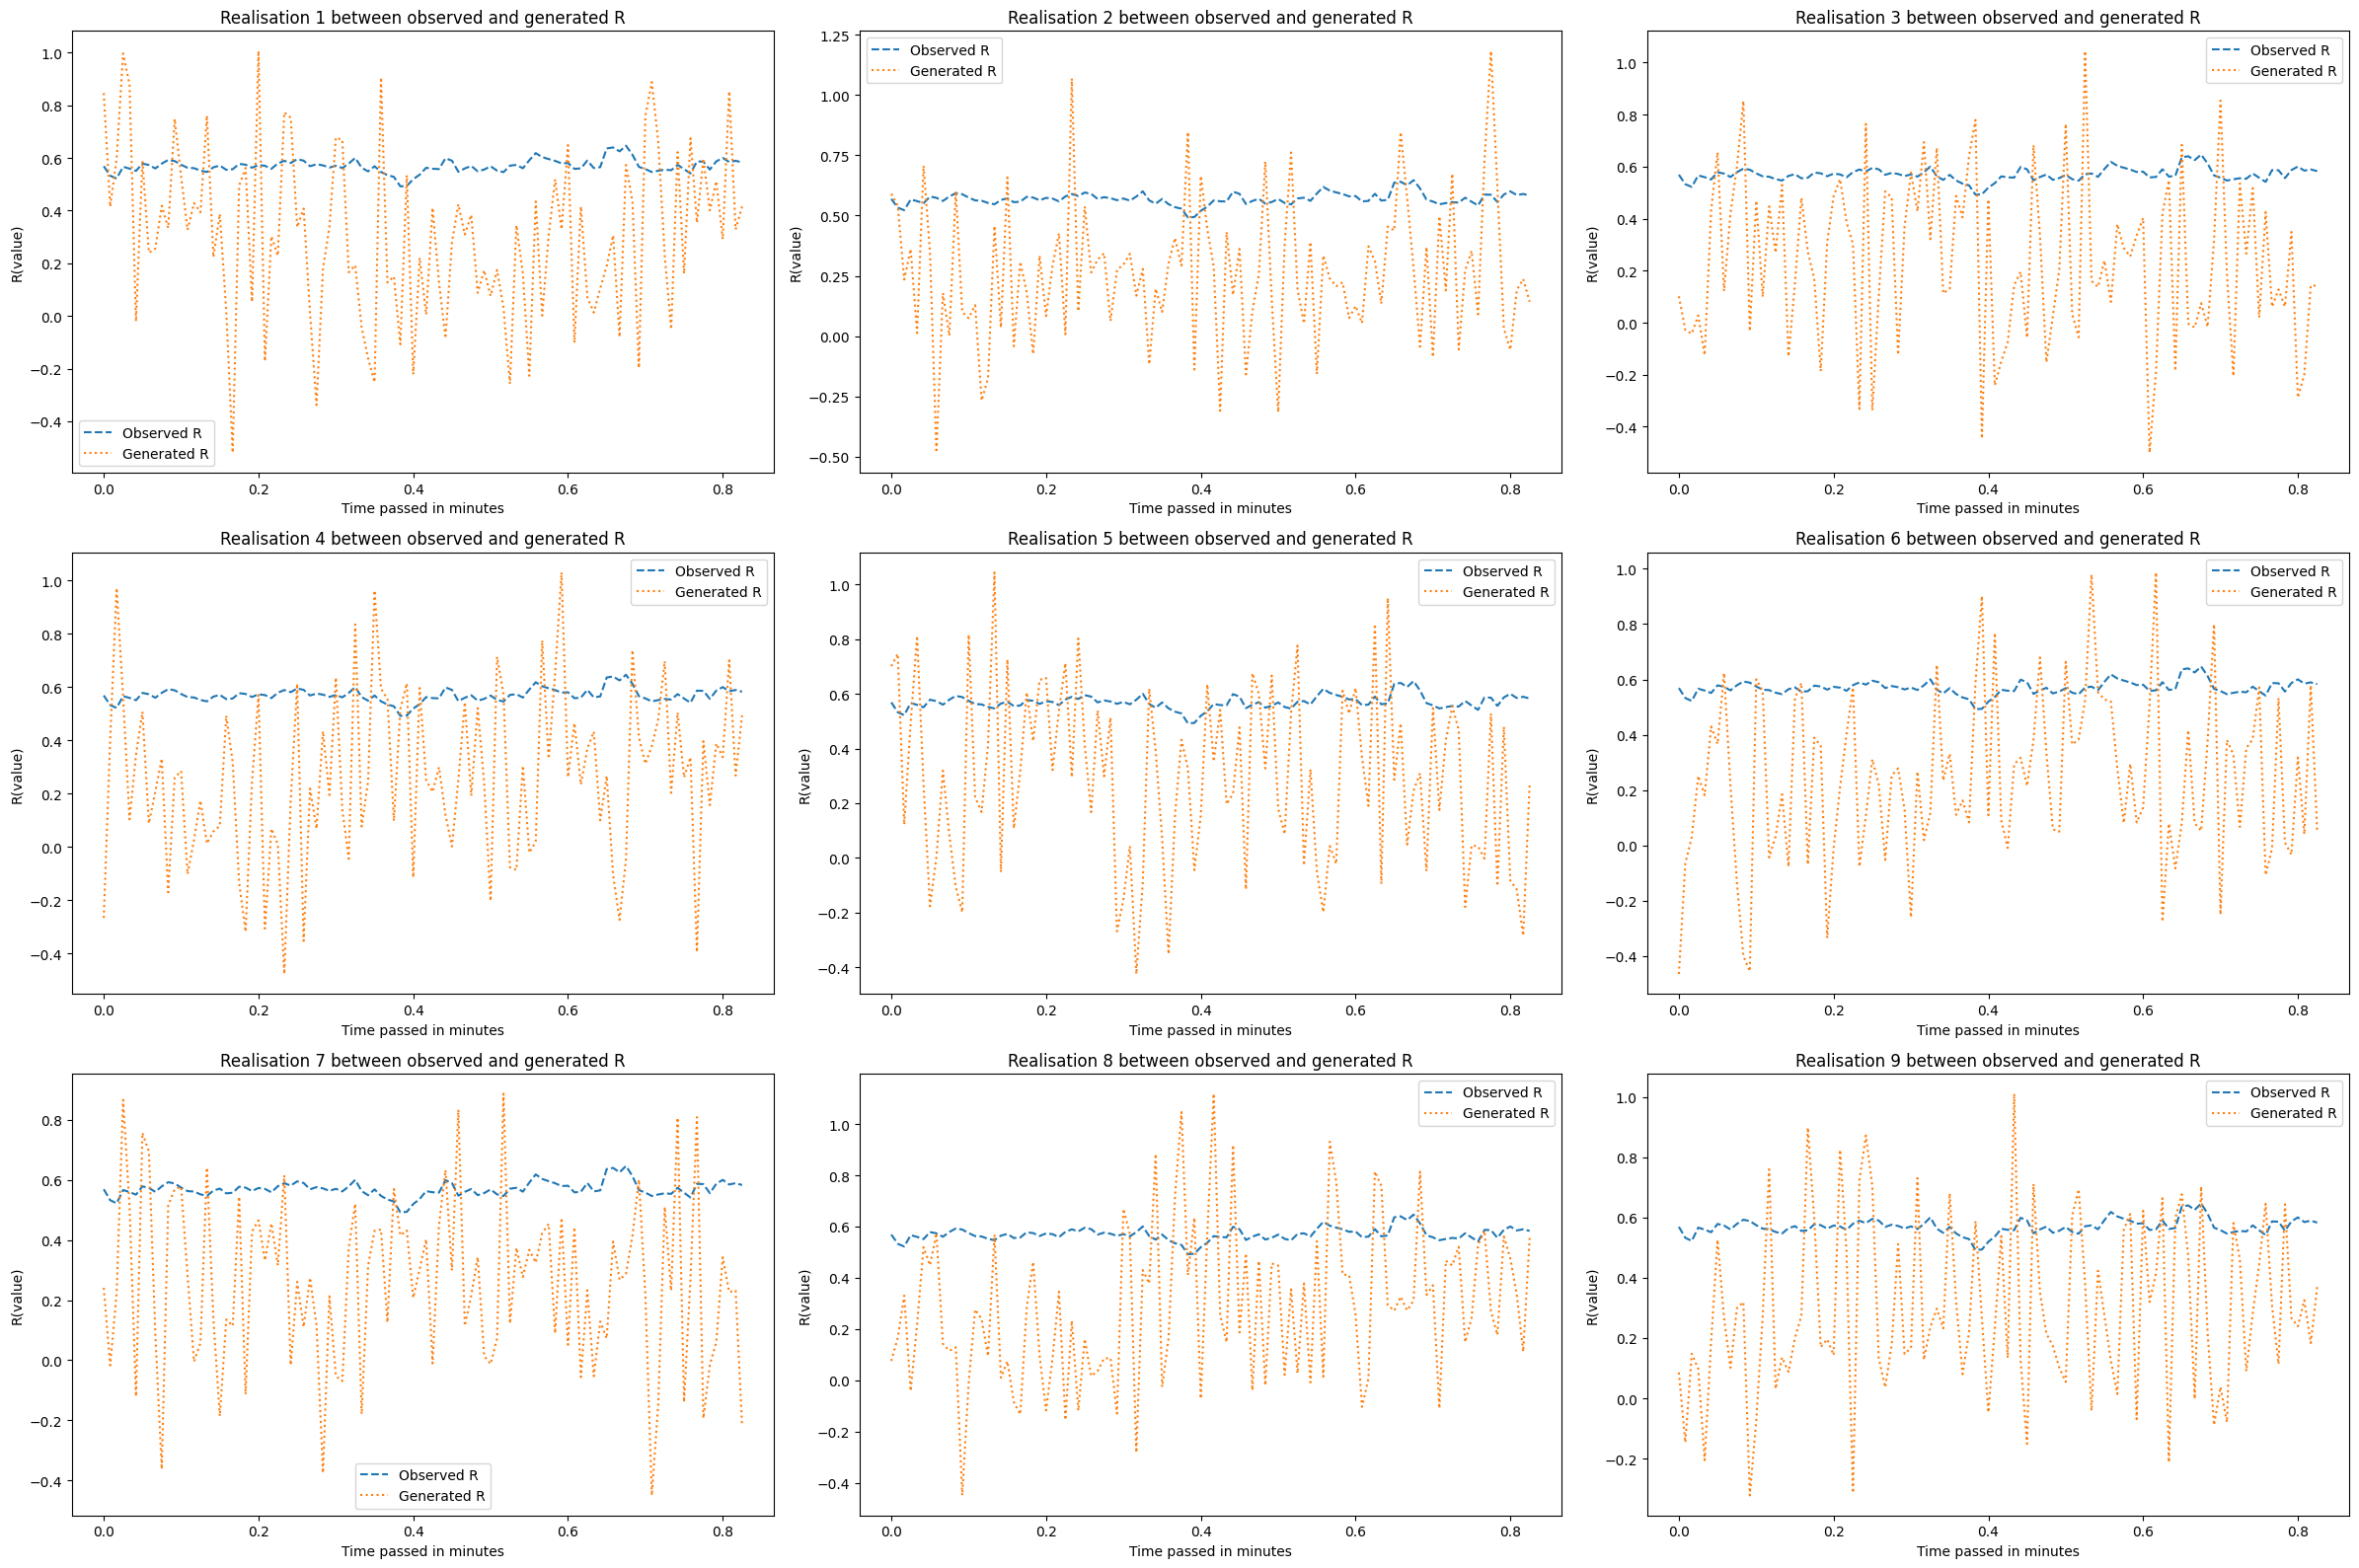

In [45]:
def meanR(SpO2, parameters):
    ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940 = parameters
    num = SpO2 * ePS_HBO2_660 + (1 - SpO2) * ePS_HB_660
    den = SpO2 * ePS_HBO2_940 + (1 - SpO2) * ePS_HB_940
    return num / den

def generate (SpO2, parameters,n = 1,seed = 0):
    np.random.seed(seed)
    sigma_square,ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940 = parameters
    SpO2_normal = SpO2 /100
    mean = meanR(SpO2_normal, [ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940])
    matrix = np.zeros((n,len(SpO2_normal)))
    for i in range(n):
        matrix[i] = np.random.normal(mean, np.sqrt(sigma_square), len(SpO2_normal))
    return matrix

initial_sigma_square = 0.1
realisation = 3
r_test = generate(spo2, [initial_sigma_square,EPS_HBO2_660, EPS_HB_660, EPS_HBO2_940, EPS_HB_940], n = (realisation* realisation))
fig,axs = plt.subplots(figsize=(24,16),nrows =realisation, ncols = realisation)
axs = axs.flatten()
for i in range((realisation * realisation)):
    axs[i].plot(t_spo2[0:100], r_resampled[0:100], label='Observed R', linestyle='dashed')
    axs[i].plot(t_spo2[0:100], r_test[i][0:100], label='Generated R', linestyle='dotted')
    axs[i].set_xlabel('Time passed in minutes')
    axs[i].set_ylabel('R(value)')
    axs[i].legend()
    axs[i].set_title(f'Realisation {i+1} between observed and generated R')

plt.tight_layout()
plt.show()




<div class="alert alert-success">

**Exercise.** Write a `log_likelihood` function that takes the same arguments as `generate`, along with a ratio ($R$), and returns the log likelihood of this ratio according to the probabilistic model.

</div>

In [ ]:
def log_likelihood(parameters, r):
    sigma_square,ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940= parameters [:5]
    SpO2  = parameters[5:]
    SpO2_norm = SpO2 /100
    r_mean = meanR(SpO2_norm, [ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940])

    return np.sum(norm.logpdf(r,loc = r_mean,scale=np.sqrt(sigma_square)))


<div class="alert alert-success">
    
**Exercise**. For simplicity, subsample only one every 200 ratios ($R$) and one every 200 oxygen saturation ($\text{SpO2}$).
    
</div>

In [ ]:
r_200 = r_resampled[::200]
spo2_200 = spo2[::200]


(30,) (30,)


<div class="alert alert-success">

**Exercise.** Using the observed ratios ($R$) and your `log_likelihood` function, infer the oxygen saturation data ($\text{SpO2}$) and the 5 parameters, using the maximum of likelihood estimator (MLE). Choose your parametrization and initial guess wisely. Discuss the results.

</div>

In [57]:
def negative_log_likelihood(parameters, r):
    return -log_likelihood(parameters, r)

initial_parameters = np.concatenate([np.array([initial_sigma_square, EPS_HBO2_660, EPS_HB_660, EPS_HBO2_940, EPS_HB_940]), spo2_200])
bound = [(1e-5, None), (1e-5,EPS_HBO2_660 * 2) ,(1e-5,EPS_HB_660*2), (1e-5,EPS_HBO2_940*2), (1e-5,EPS_HB_940*2)] + [(0,100)] * len(spo2_200)

result = minimize(negative_log_likelihood,initial_parameters ,args=(r_200), bounds=bound)

print(result)
print(result.x[:5])



  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -145.12572489667517
        x: [ 1.000e-05  2.902e+02 ...  5.374e+01  8.973e+01]
      nit: 320
      jac: [ 1.499e+06 -5.116e-05 ...  2.032e-03  4.491e-03]
     nfev: 13392
     njev: 372
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>
[1.00000000e-05 2.90206206e+02 3.12028525e+03 1.49625745e+03
 7.66181900e+02]


For the initial guess I used the things that I used since the begininning of this part for the 4 parameters I used what the teachers provided and the variance to 0.1 for the bounds I know the variances must be positive and for the 4 parameters I let's they can have a huge range of values but they will use only a small range and for the spo2 we know from biology constraints is between 0 to 100 

There is a convergence to this problem firstly .We can observe that the function minimizes will take for the variance the lower bound that I assume for the problems. For the 4 others parameters they have different value but very similar to the initial guess , they stay in the range of the initial guess. The result are very negative for a log function that represents this will fit the r_200 that as been provided . This model is not very flexible and it certain of the choose that he make and will not provide nearly any noise. 

<div class="alert alert-success">
    
**Exercise**. Plot the distribution of ratios from the fitted model throughout the subsampled time series and compare it to the observed ratios. Then, ignore the temporal aspect and display the marginal distributions of ratios from the fitted model, along with the marginal observed distribution of ratios. Discuss the results.
        
</div>

(30,)


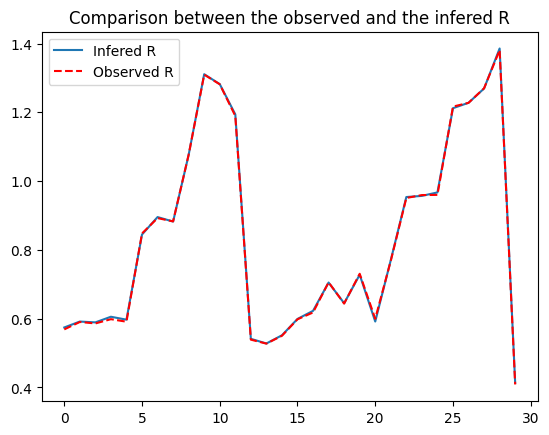

In [ ]:
mle_new_parameters = result.x[:5]
mle_r = generate(result.x[5:], mle_new_parameters, n=1, seed=0)[0]

fig = plt.figure()
ax = plt.axes()

ax.plot(mle_r, label='Infered R')
ax.plot(r_200, label='Observed R', linestyle='dashed', color = 'red')
plt.title("Comparison between the observed and the infered R")
plt.legend()
plt.show()



By plotting the grapphics, we can confirm what I said previously about the R_200 is very fitted in graphcs the 2 lines are basically the same and we can see tthat they will follow the same pattern.

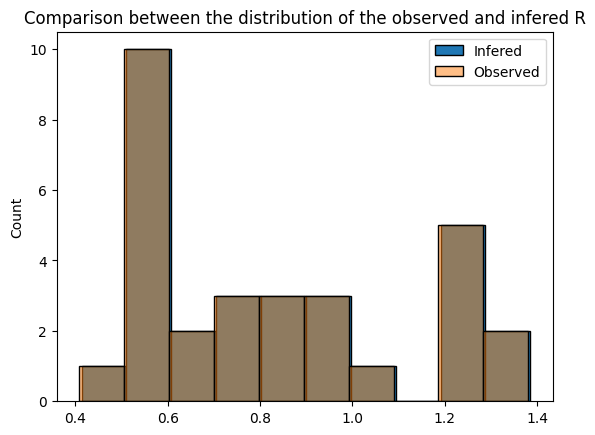

In [ ]:
fig = plt.figure()
ax = plt.axes()
sns.histplot(mle_r, label='Infered',bins = 20 ,alpha=1,ax = ax)
sns.histplot(r_200, label='Observed',bins = 20,alpha=0.5,ax = ax)

plt.title('Comparison between the distribution of the observed and infered R')
plt.legend()
plt.show()

We can see also here that the distribution of the observed R and the Infered R are basically the same with a very small difference between the observed and infered R the range of the value of those two are confused. We can expected such as the following result by the number of parameters to fit the number of observations There is 5 more parameters to fit than the number of observations.

<div class="alert alert-success">
    
**Exercise**. Finally, plot the SpO2 values infered by MLE, together with the SpO2 values infered by the empirical model, and compare it to the SpO2 measurements. Give your observations, compare the results obtained by the two models, and discuss their limitations.
        
</div>

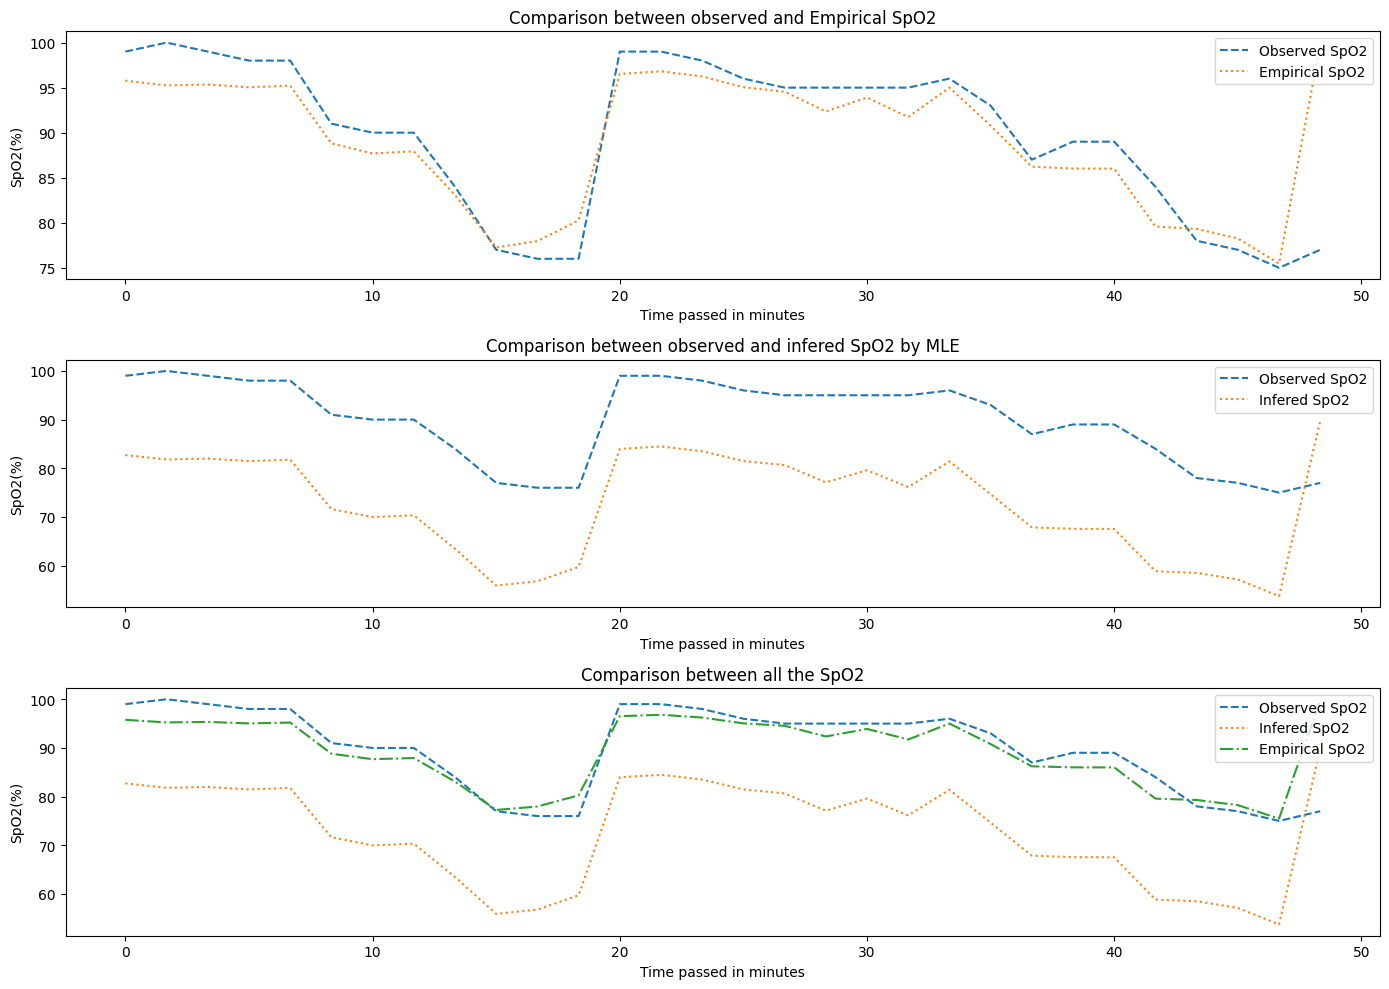

In [70]:
empirical_200 = empirical_law(spo2_200, r_200)

fig,axs = plt.subplots(nrows=3, ncols=1, figsize=(14,10))
axs = axs.flatten()

axs[0].plot(t_spo2[::200], spo2_200, label='Observed SpO2', linestyle='dashed')
axs[0].set_xlabel('Time passed in minutes')
axs[0].plot(t_spo2[::200], empirical_200, label='Empirical SpO2', linestyle='dotted')
axs[0].set_ylabel('SpO2(%)')
axs[0].legend(loc='upper right')
axs[0].set_title('Comparison between observed and Empirical SpO2')
axs[1].plot(t_spo2[::200], spo2_200, label='Observed SpO2', linestyle='dashed')
axs[1].set_xlabel('Time passed in minutes')
axs[1].plot(t_spo2[::200], result.x[5:], label='Infered SpO2', linestyle='dotted')
axs[1].set_ylabel('SpO2(%)')
axs[1].legend(loc='upper right')
axs[1].set_title('Comparison between observed and infered SpO2 by MLE')
axs[2].plot(t_spo2[::200], spo2_200, label='Observed SpO2', linestyle='dashed')
axs[2].set_xlabel('Time passed in minutes')
axs[2].plot(t_spo2[::200], result.x[5:], label='Infered SpO2', linestyle='dotted')
axs[2].plot(t_spo2[::200], empirical_200, label='Empirical SpO2', linestyle='dashdot')
axs[2].set_ylabel('SpO2(%)')
axs[2].legend(loc='upper right')
axs[2].set_title('Comparison between all the SpO2')
plt.tight_layout()
plt.show()




What I wrote before for the empirical spo2 remains the same but having only one observations by 200 : 
(Same as above)

We can see that the look of the empirical SpO2 looks like the same of the observed SpO2 with higher variance between each value but stay coherent in the form in the global. The empirical SpO2 will will give us the majority of the time values below the observed value except when we arrive near 42 where the empirical SpO2 will go higher than the observed one. We can also see the minimum of the values is with the empirical SpO2 who the concetration is below 70%. Where this is the case for a human this will be dangerous and can lead to false positives when trigger alerts when the spo2 is too low but in reality it is acceptable.

For the infered one, we can see this is a bad version the curve is below the observed value nearly always by a difference of 10 to 20 percents easily with ths problem we are going to have more false positives and more issue but we can notice that the curve will follow the same shape as the observed one. We can expect this result by the fact that we try in the model to fit R and not SPO2. With the empirical SpO2 there is a relationship between the observed value and the SPO2 predicted. Here there is not such relationship to have this conclusion.

For the MLE problems , there is a problem of scaling to fit a biggest array of R the number of parameters will also grows up and we are going to have more time to fit the R and the lack of noise(variance too small) than express a problem to explain other possible observations that we can have. For the empirical version. If the have R we can predict easily the Spo2 by the formula and inverse so we can't justify if with a R this will not predict the correct SpO2 and finding a explanation.

